# Library Computer Usage Analysis

## Computer Utilization Data by Date-Time

### Part 1
- Conduct Decriptive Analytics (Mean, Median, Quartile) calculation by each division of Date-Time (most probably year or 6 month duration, if you have shorter use 1 month)
- Calculate divergence of mean and median in your data
- Visualize the data and draw inferences

In [1]:
import pandas as pd
import numpy as np
import gzip
import pickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
with gzip.open(r'../data/LibData.pkl.gz') as f:
    libraryData = pickle.load(f)

In [4]:
libraryData.head(3)

,BL001,BL002,CITI001,CITI002,CITI003,CITI004,CITI005,CITI006,CITI007,CITI008,...,TL5002,TL6001,TL6002,TL7001,TL702,TL801,TL802,TL90003,TL901,TL902
2010-03-24 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-24 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-24 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In keeping with the directive of a 'division of date-time' it makes sense to separate the data into semesters. Previous findings determined that there were precipitous changes in the data during intersession periods.

In [5]:
semTable = pd.read_csv(r'../data/semesters.csv',parse_dates=True,header=0)
semTable.head(3)

,semester,startDate,endDate
0,SP10,1/19/10,5/12/10
1,SU10,5/17/10,8/9/10
2,FA10,8/23/10,12/15/10


The `libraryData` dataframe is formatted such that the rows are hours of the day, the columns are the computer names, and the intersection is the percent (as a decimal) of the hour that the machine was considered `in-use`. Below is a single partition showing the output of the data.

In [6]:
libraryData.iloc[66368:66370,37:48]

,CRR011,CRR012,CRR013,CRR014,CRR015,CRR016,CRR017,CRR018,CRR019,CRR020,CRR021
2017-10-18 20:00:00,1.000000,0.628319,1.000000,0.642717,0.0,0.0,1.000000,0.164845,1.000000,0.591785,1.000000
2017-10-18 21:00:00,0.989054,0.000000,0.664845,0.756433,0.0,0.0,0.759883,0.753006,0.991185,0.340238,0.409653


For the sake of comparison, the machine data will be separated by semester and then summed by machine. This will return the number of hours a machine was considered `in-use` for a semester.

In [7]:
seriesList = []
for i,row in semTable.iterrows():
    semName = row['semester']
    staDate = row['startDate']
    endDate = row['endDate']
    dateMask = (libraryData.index >= staDate) & (libraryData.index <= endDate)
    sumSeries = libraryData[dateMask].sum()
    sumSeries.name = semName
    seriesList.append(sumSeries)
fullData = pd.concat(seriesList,axis=1)

The above operation takes the full `libraryData` dataframe and isolates a specific semester. It then takes the hourly percentages and sums them per machine, creating a new series. Each of these series are appended to a list, and then a new dataframe is created from the concatenation of these series, as seen below:

In [8]:
fullData.head()

,SP10,SU10,FA10,SP11,SU11,FA11,SP12,SU12,FA12,SP13,...,FA14,SP15,SU15,FA15,SP16,SU16,FA16,SP17,SU17,FA17
BL001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,341.246004,487.561149,...,376.664551,313.213418,71.617274,236.181679,187.716963,718.664095,468.562981,169.015489,23.385220,74.027389
BL002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308.131863,1227.797128,...,520.444652,423.087819,49.533248,286.088283,287.746293,18.400199,318.138754,370.755695,21.275550,91.075791
CITI001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476.990593,300.434544,...,412.793626,241.716375,131.579160,274.967037,220.307864,9.349383,334.790466,119.953131,106.961886,116.464382
CITI002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231.056434,179.169701,...,229.633192,233.656031,22.179986,365.204838,213.583991,316.766577,423.552274,96.447835,105.871731,105.350115
CITI003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,303.149397,139.004229,...,219.941686,226.419678,19.023343,228.462875,221.765641,268.459412,403.403500,130.408121,30.436416,94.017167


There are some machines whose logon state data causes some unnecessary troughs and peaks in the data above. For example, the 'requiresLogon' machines are always considered `in-use` and should be excluded. Creating a merge using the `../data/computerAttributes.csv` file.

In [9]:
attrsList = pd.read_csv(r'../data/computerAttributes.csv',header=0)
attrsList.head()

,dbID,computerName,requiresLogon,isDesktop,inJackson,location,is245,floor,numMonitors,largeMonitor,adjacentWindow,collaborativeSpace,roomIsolated,inQuietArea
0,187,BL001,1.0,1.0,1.0,Tower,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,188,BL002,1.0,1.0,1.0,Tower,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,105,CITI001,1.0,1.0,1.0,CITI Lab,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0
3,106,CITI002,1.0,1.0,1.0,CITI Lab,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0
4,107,CITI003,1.0,1.0,1.0,CITI Lab,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
fullDataAttrs = pd.merge(fullData,attrsList,left_index=True,right_on='computerName')
fullDataAttrs.head(3)

,SP10,SU10,FA10,SP11,SU11,FA11,SP12,SU12,FA12,SP13,...,inJackson,location,is245,floor,numMonitors,largeMonitor,adjacentWindow,collaborativeSpace,roomIsolated,inQuietArea
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,341.246004,487.561149,...,1.0,Tower,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308.131863,1227.797128,...,1.0,Tower,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476.990593,300.434544,...,1.0,CITI Lab,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0


In [11]:
fullDataAttrsMasked = fullDataAttrs[fullDataAttrs['requiresLogon'] == True]

In looking at the semesters, it appears that the summer semester(s) tend to vary too greatly from spring and fall. Moving forward it seems to be more representative of the data in question to compare only spring and fall.

In [12]:
graphSems = ['FA15','SP16','SU16','FA16','SP17','SU17']
print fullDataAttrsMasked.loc[:,graphSems].describe()
print "--------------------------------------------"
print "Semester Medians:"
print fullDataAttrsMasked.loc[:,graphSems].median()
print "--------------------------------------------"
print "Difference in Mean and Median:"
print fullDataAttrsMasked.loc[:,graphSems].mean() - fullDataAttrsMasked.loc[:,graphSems].median()

              FA15         SP16         SU16         FA16         SP17  \
count   290.000000   290.000000   290.000000   290.000000   290.000000   
mean    517.510859   501.454491   259.000225   611.953808   521.330283   
std     467.613954   462.354457   391.737352   429.099117   345.602953   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     189.789102   115.823021     0.046022   371.874043   256.693943   
50%     497.026792   458.070285    95.558716   594.887560   460.106304   
75%     727.903116   690.558259   312.359777   864.601645   822.653703   
max    2785.000000  2737.000000  2113.000000  2620.297257  2184.913269   

              SU17  
count   290.000000  
mean    153.562643  
std     349.393529  
min       0.000000  
25%      13.124060  
50%      44.093722  
75%     129.370013  
max    2017.000000  
--------------------------------------------
Semester Medians:
FA15    497.026792
SP16    458.070285
SU16     95.558716
FA16    594.887560
SP17 

This is a stacked bar graph of the per machine data for the semesters above.

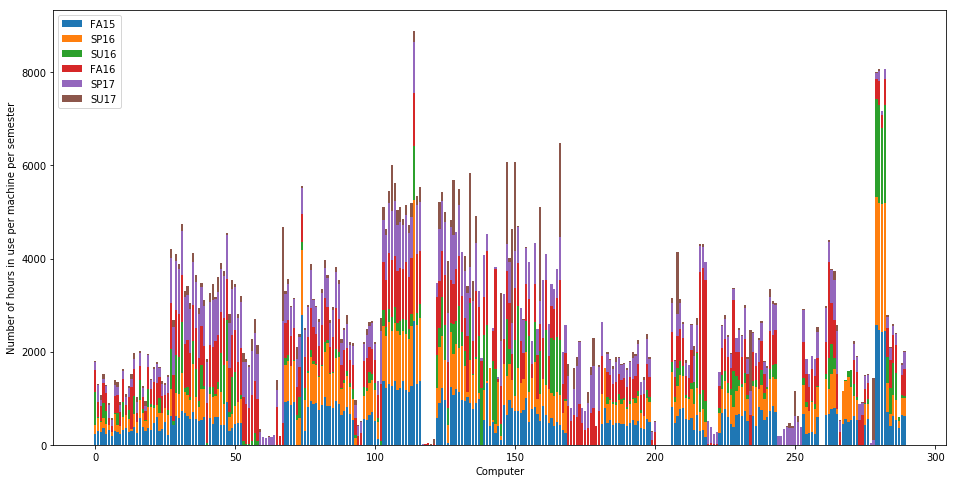

In [13]:
graphSems = ['FA15','SP16','SU16','FA16','SP17','SU17']
barBase = 0 # this will be the placeholder for the bottom of each successive graph in the stack.
graphInd = range(0,fullDataAttrsMasked.shape[0])
plt.figure(num=None, figsize=(16, 8), facecolor='w', edgecolor='k')
plt.xlabel('Computer')
plt.ylabel('Number of hours in use per machine per semester')
for i in range(len(graphSems)):
    plt.bar(graphInd,fullDataAttrsMasked.loc[:,graphSems[i]],label=graphSems[i],bottom=barBase)
    barBase += fullDataAttrsMasked.loc[:,graphSems[i]]
plt.legend();

Creating a histogram of the data from the listed semesters:

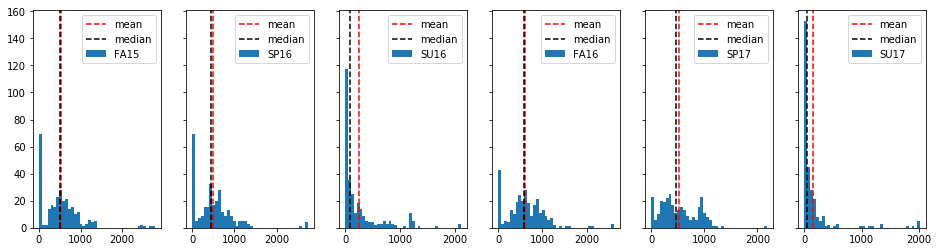

In [14]:
histChart, histAxes = plt.subplots(1,len(graphSems),sharey=True,tight_layout=False,figsize=(16,4))
for i in range(len(graphSems)):
    histAxes[i].hist(fullDataAttrsMasked.loc[:,graphSems[i]],bins=40,label=graphSems[i])
    histAxes[i].axvline(x=fullDataAttrsMasked.loc[:,graphSems[i]].mean(),
                        label = "mean", color = "red", linestyle="dashed")
    histAxes[i].axvline(x=fullDataAttrsMasked.loc[:,graphSems[i]].median(),
                        label = "median", color = "black", linestyle="dashed")
    histAxes[i].legend()


#### Analysis:
Visualization of the data appears to confirm a couple of observations:
- There appears to be a peak of machines whose utilization is at or near zero for the semester.
- The number of zero utilization machines increases in the summers.
- The mean and median for Fall and Spring semesters are close, while the same for the summer semester are further apart.
- With a few outliers, it appears that most machines' utilization is packed close to the mean/median.
- The outliers are extreme, and are likely due to anomalous data, e.g.:
    - Machine may be left on when a user walks away without logging out.
    - Machine is in a diagnostic/repair status which requires it to be logged in for extended periods.
    - Machines left logged in at close accrue usage hours when library is not open.

### Part 2
- Conduct Probablity distibution analysis based on the data. Analyze your data based on the type of distribution it best fits (for PDF and CDF)
- Conduct Method of Moments analysis on your data to suggest the best fit distribution. Visualize the results

One of the more popular areas in the library is the Information Commons. It is open 24 hours a day, 5 days a week, and has fifteen machines with dual monitors. Testing to find out the probability over the course of a day that one of the machines here has been used.

In [15]:
sem = 'SP17'
staDate = semTable[semTable['semester'] == sem].values[0][1]
endDate = semTable[semTable['semester'] == sem].values[0][2]
dateMask = (libraryData.index >= staDate) & (libraryData.index <= endDate)

In [16]:
probTest = libraryData.loc[dateMask,'INC001':'INC015']

This removes the date from the index so that the later mean operation can be grouped by hour, independent of day.

In [17]:
probTest.index = probTest.reset_index()['index'].apply(lambda x: x - pd.Timestamp(x.date()))

In [18]:
hourlyMeans = probTest.groupby(pd.TimeGrouper("H")).mean()

In [19]:
hourlyMeans.index

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00',
                '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
                '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00',
                '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
               dtype='timedelta64[ns]', name=u'index', freq='H')

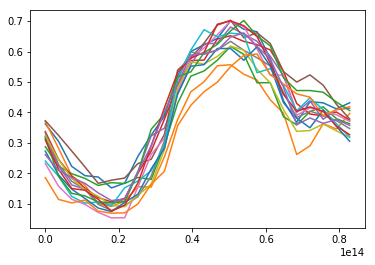

In [20]:
plt.plot(hourlyMeans.index,hourlyMeans);

In [21]:
probTestMean = probTest.mean()
probTestVar = probTest.var()

In [22]:
alphaMoment = probTestMean ** 2 / probTestVar
betaMoment = probTestVar / probTestMean
print alphaMoment
print betaMoment

INC001    0.969851
INC002    0.631403
INC003    0.708296
INC004    0.860610
INC005    0.809580
INC006    0.945623
INC007    0.707129
INC008    0.710540
INC009    0.667997
INC010    0.736905
INC011    0.644122
INC012    0.557176
INC013    0.838781
INC014    0.821929
INC015    0.836153
dtype: float64
INC001    0.432618
INC002    0.517861
INC003    0.506421
INC004    0.456157
INC005    0.485212
INC006    0.460089
INC007    0.520047
INC008    0.516251
INC009    0.519434
INC010    0.505238
INC011    0.541969
INC012    0.584380
INC013    0.481426
INC014    0.472963
INC015    0.457398
dtype: float64


### Part 3
- Formulate a null hypothesis and evaluate it, perform correlation measures, and construct a linear regression model
- Compare with the variable with other variables in your project

#### Null Hypothesis: 
Location of machines has no effect on the average usage of a machine.

Importing gate count statistics

In [23]:
gateCounts = pd.read_csv(r'../data/FullGateCounts.csv')
gateCounts.date = gateCounts.date.apply(pd.to_datetime)
gateCounts.set_index('date',inplace=True)
gateCounts.head(3)
gateCounts['patrons'] = ((gateCounts['CG-CLOSE'] - gateCounts['CG-OPEN'])+(gateCounts['CON-CLOSE'] - gateCounts['CON-OPEN']))/2
gateCounts.head(3)

,CG-OPEN,CG-CLOSE,CON-OPEN,CON-CLOSE,patrons
date,,,,,
2010-07-01,258496.0,259594.0,693996.0,695730.0,1416.0
2010-07-02,259618.0,260250.0,695744.0,696834.0,861.0
2010-07-03,260252.0,260374.0,696836.0,696970.0,128.0


Selecting Spring 2017 as the test semester, as it is the most recent complete Spring or Fall semester.

In [24]:
sem = 'SP17'
staDate = semTable[semTable['semester'] == sem].values[0][1]
endDate = semTable[semTable['semester'] == sem].values[0][2]
dateMask = (libraryData.index >= staDate) & (libraryData.index <= endDate)

Merging the list of machines with the table of attributes to exclude machines which do not require a logon, but also to be able to separate the machines by region.

In [25]:
fullSemesterWithAttrs = libraryData[dateMask].groupby(pd.Grouper(freq="D")).sum().T.merge(attrsList,left_index=True,right_on='computerName').set_index('computerName')
fullSemesterWithAttrs.loc[fullSemesterWithAttrs.location == 'Checkout Desk','floor'] = "1"

In [26]:
meansByRegion = fullSemesterWithAttrs[(fullSemesterWithAttrs.requiresLogon==True)].groupby(['location','floor']).mean().iloc[:,0:114]
meansByRegion.reset_index(level=[0,1],inplace=True)
meansByRegion['fullLocation'] = meansByRegion['location'] + meansByRegion['floor']
meansByRegion.drop(['location','floor'],axis=1,inplace=True)
#Spaces cause problems with linear regression calculations
meansByRegion['fullLocation'] = meansByRegion['fullLocation'].str.replace(" ","_") 
meansByRegion.set_index('fullLocation',inplace=True)

Merging the regional means with the table of gate counts per day. The first four columns dropped are used in the calculation of the 'patrons' column; the Music Library stats would be incorrectly correlated with Jackson Library gate counts; and The 'Tower0' column has a less-than-zero correlation.

In [27]:
meansAndGate = pd.merge(meansByRegion.T,gateCounts,left_index=True,right_index=True)
meansAndGate.drop(['CG-OPEN','CG-CLOSE','CON-OPEN','CON-CLOSE','Music_Libraryna','Music_Library1','Tower0'],axis=1,inplace=True)

With a correlation above .9 in some areas, machine usage and patron gate is very strongly correlated with location of machine, as seen below:

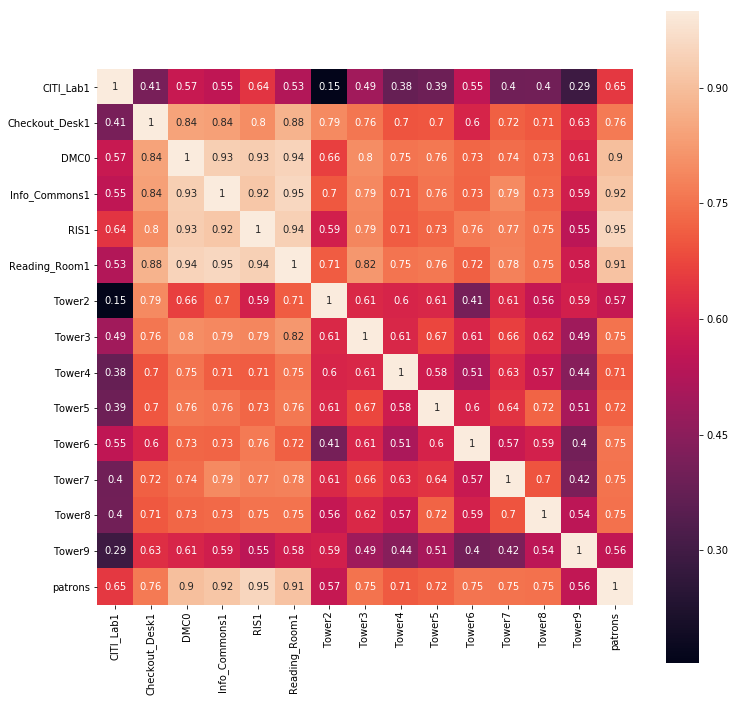

In [28]:
plt.figure(figsize=(12,12))
sns.heatmap(meansAndGate.corr(),annot=True,square=True);

#### Linear Regression:

Looking at the heatmap above, it appears that there are four regions whose correlation is above .9:
- Digital Media Commons (DMC)
- Information Commons
- Reference, and Instruction Services (RIS1)
- Reading Room

Calculating the Linear Regression model for these four areas:

In [29]:
regions = ['DMC0','Info_Commons1','Reading_Room1','RIS1',]
lrModel = []

for i in range(len(regions)):
    lrModel.append(smf.ols(formula='patrons ~ '+regions[i], data=meansAndGate).fit())
    print lrModel[i].params

Intercept   -118.867278
DMC0         798.001952
dtype: float64
Intercept       -364.592805
Info_Commons1    463.095391
dtype: float64
Intercept       -515.099741
Reading_Room1    594.448591
dtype: float64
Intercept    192.380338
RIS1         993.356145
dtype: float64


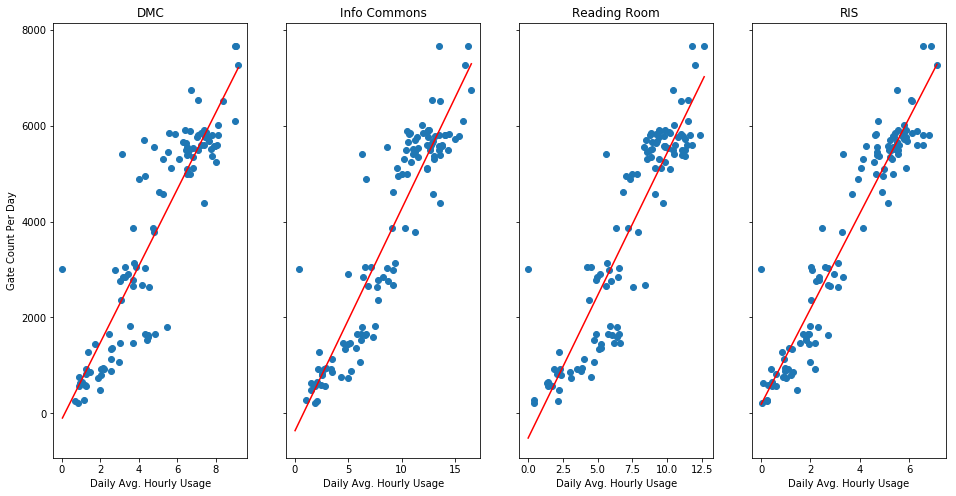

In [52]:
linChart, linAxes = plt.subplots(1, len(regions), sharey=True, figsize=(16, 8))
linAxes[0].set_ylabel('Gate Count Per Day')
for i in range(len(regions)):
    lrX = pd.DataFrame({regions[i]: [meansAndGate[regions[i]].min(), meansAndGate[regions[i]].max()]})
    lrPredict = lrModel[i].predict(lrX)
    linAxes[i].set_xlabel('Daily Avg. Hourly Usage')
    linAxes[i].scatter(meansAndGate.loc[:,regions[i]].values,meansAndGate.loc[:,'patrons'].values)
    linAxes[i].plot(lrX,lrPredict,color='red')
    linAxes[i].set_title(regions[i][:-1].replace("_"," "))